<p style="font-size:200%;font-weight:bold">Crashes</p>

- Author: Yichen Luo
- Date: 20221010

In [2]:
import pandas as pd
import threading
import requests
import time
import os
import datetime
import re
import string
import random
import numpy as np
import seaborn as sns;sns.set_theme(color_codes=True)
import warnings
from web3 import Web3
from hexbytes import HexBytes

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.core.interactiveshell import InteractiveShell
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore")


RD = '/home/team_defi/02_rdata/'
WD = '/home/team_defi/03_wdata/'
RES = '/home/team_defi/04_result/'
InteractiveShell.ast_node_interactivity = 'all'

# Function

In [6]:
def chain_info(chain):
    dexes = {'ethereum':['uniswapv3_ethereum', 'uniswapv2_ethereum', 'sushiswap_ethereum'],
             'binance':['pancake_binance', 'biswap_binance', 'apeswap_binance', 'babyswap_binance', 'jetswap_binance'],
             'avalanche':['traderjoe_avalanche', 'pangolin_avalanche'],
             'fantom':['spookyswap_fantom', 'spiritswap_fantom'],
             'polygon':['sushiswap_polygon', 'apeswap_polygon', 'jetswap_polygon']
            }
    
    dex = dexes[chain]
    return dex

def token_dollar_price_date(contract, chain, date):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
        
        priceUSD = 0
        dex_num = 0
        avg_priceUSD = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                price_info = csv.loc[(pd.to_datetime(csv['date']) == pd.to_datetime(date))]
                
                if price_info.shape[0] != 0:
                    price = price_info['priceUSD'].values[0]
                    if price != 0:  
                        priceUSD += price
                        dex_num += 1

        if dex_num != 0: 
            return priceUSD/dex_num
        if dex_num == 0:
            return 0
        
def token_dollar_price(contract, chain, timestamp):
    
        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

        date = timestamp.strftime('%Y-%m-%d')
        
        priceUSD = 0
        dex_num = 0
        avg_priceUSD = 0

        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]
            
            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                price_info = csv.loc[(pd.to_datetime(csv['date']) > pd.to_datetime(timestamp) - datetime.timedelta(days=1))&
                                  (pd.to_datetime(csv['date']) < pd.to_datetime(timestamp))]
                
                if price_info.shape[0] != 0:
                    price = price_info['priceUSD'].values[0]
                    if price != 0:  
                        priceUSD += price
                        dex_num += 1

        if dex_num != 0: 
            return priceUSD/dex_num
        if dex_num == 0:
            return 0
        
def token_return(day, contract, chain, date):

    start_date = (pd.to_datetime(date) + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
    end_date = (pd.to_datetime(date) + datetime.timedelta(days=day)).strftime('%Y-%m-%d')

    start_price = token_dollar_price_date(contract=contract, chain=chain, date=start_date)
    end_price = token_dollar_price_date(contract=contract, chain=chain, date=end_date)
    
    if (end_price == 0)|(start_price==0):
        return np.nan
    else:
        return np.log(end_price/start_price)

# DeFi Projects

## All Token Projects List

In [7]:
# chains = ['ethereum', 'binance', 'avalanche', 'fantom', 'polygon']
# dfs = []
# for chain in chains:
#     df = pd.read_csv(f'/home/yichen/team_defi/04_result/insider_trading/root_list/root_list_final/root_{chain}.csv')
#     df['chain'] = chain
#     dfs.append(df)
    
# dfs = pd.concat(dfs)
# dfs.drop_duplicates(['contractAddress', 'chain'], inplace=True)
# dfs.drop(columns=['root'], inplace=True)
# dfs['status'] = -1
# dfs.to_csv(f'{WD}crash/list/list.csv', index=False)

## Price Panel

In [9]:
dfs = pd.read_csv(f'{WD}crash/list/list.csv')
total = dfs.shape[0]
done = dfs.loc[dfs['status'] != -1].shape[0]

for idx, row in dfs.loc[dfs['status'] == -1].iterrows():
    try:
        done += 1
        contract = row['contractAddress']
        chain = row['chain']

        contractAddress_lower = contract.lower()
        contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)

        dex_num = 0

        panel = []
        for dex in chain_info(chain):
            lst = pd.read_csv(f'{WD}/dex_price/list_all/{dex}.csv')
            csv_info = lst.loc[((lst['contractAddress'] == contractAddress_lower)|
                                (lst['contractAddress'] == contractAddress_upper))]

            if csv_info['contractAddress'].values[0] == contractAddress_lower:
                contractAddress = contractAddress_lower
            else:
                contractAddress = contractAddress_upper

            status = csv_info['status'].values[0]
            dexn = csv_info['dex'].values[0]

            if status == 0: 
                continue
            elif dexn == 0:
                continue
            else:
                csv = pd.read_csv(f'{WD}dex_price/csv_all/{contractAddress}_{dex}.csv') 
                csv = csv.loc[:, ['priceUSD', 'date']]
                panel.append(csv)
                dex_num += 1

        if dex_num != 0:
            panel = pd.concat(panel)
            panel = panel.loc[panel['priceUSD']!=0]
            if panel.shape[0] == 0:
                dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 0
                dfs.to_csv(f'{WD}crash/list/list.csv', index=False)
                print(f'{contract} Zero Price Info, {done}/{total}')
                continue


            start_date = panel['date'].min()
            end_date = panel['date'].max()
            avg = panel.groupby('date')['priceUSD'].mean().reset_index()
            avg['contractAddress'] = contract
            avg['chain'] = chain
            avg['date'] = pd.to_datetime(avg['date'])
            avg.to_csv(f'{WD}crash/csv/{contract}_{chain}_avg.csv', index=False)

            ret = pd.DataFrame({'date':pd.date_range(start = start_date, end=end_date)})
            ret['contractAddress'] = contract
            ret['chain'] = chain

            for day in range(-5, 6):
                ret[f'ret_{str(day)}'] = np.nan

            for idx_ret, row_ret in ret.iterrows():
                date = row_ret['date']
                for day in range(-5, 6):

                    start_date = (pd.to_datetime(date) + datetime.timedelta(days=day-1)).strftime('%Y-%m-%d')
                    end_date = (pd.to_datetime(date) + datetime.timedelta(days=day)).strftime('%Y-%m-%d')

                    start_info = avg.loc[avg['date'] == start_date, 'priceUSD'].values
                    end_info = avg.loc[avg['date'] == end_date, 'priceUSD'].values

                    if ((len(start_info)==0)|(len(end_info)==0)):
                        ret.loc[ret['date'] == date, f'ret_{str(day)}'] = np.nan
                    else:
                        ret.loc[ret['date'] == date, f'ret_{str(day)}'] = np.log(end_info[0]/start_info[0])

                if len(avg.loc[avg['date'] == date, 'priceUSD'].values) == 0:  
                    ret.loc[ret['date'] == date, 'priceUSD'] = np.nan
                else:
                    ret.loc[ret['date'] == date, 'priceUSD'] = avg.loc[avg['date'] == date, 'priceUSD'].values[0]
        else:
            dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 0
            dfs.to_csv(f'{WD}crash/list/list.csv', index=False)
            print(f'{contract} Zero DEX Info, {done}/{total}')
            continue

        ret.to_csv(f'{WD}crash/csv/{contract}_{chain}_ret.csv', index=False)
        dfs.loc[(dfs['contractAddress'] == contract)&(dfs['chain']==chain), 'status'] = 1
        dfs.to_csv(f'{WD}crash/list/list.csv', index=False)
        print(f'{contract} Done, {done}/{total}')

    except Exception as e:
        print(f'{contract} Error: {e}, {done}/{total}')

0x2a15de7c821baa1a727039b76d540b36b23db257 Zero DEX Info, 1/13509
0xa0fd12272cc4da86aebf9d592cdad253cbbc25fb Zero DEX Info, 2/13509
0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32 Done, 3/13509
0x506d62bf7d8a8f444f13533081dc03470483f4ea Done, 4/13509
0xcbfb937a75f8baf9d94e064cc90b1c045f7c25fa Zero Price Info, 5/13509
0x2ec878e84ac711ecb39390edf03961361a1ca43e Zero DEX Info, 6/13509
0xb30fdcc074ef57e43caa44c1a8008e2f9cde647b Zero DEX Info, 7/13509
0x0239d3a3485ec54511bee9d77d92695e443bf060 Done, 8/13509
0x18084be33d80c3fdf6e7e7deab4a4e5e26657331 Done, 9/13509
0x77d1b367221a5864af03d7a9e4e6ae2e6cd2a0ae Done, 10/13509
0xc065a04ed30471a0200da2e583bac120b129f0c5 Zero DEX Info, 11/13509
0xeed12f1e7dd745247f878070dd32c6449126fd3e Zero DEX Info, 12/13509
0x1f9840a85d5af5bf1d1762f925bdaddc4201f984 Done, 13/13509
0x834806a97938ae7270d3dfef01240206b380e716 Done, 14/13509
0x9a488708ce78e910fa07203bf2c78d7848485f77 Zero Price Info, 15/13509
0xc8afe5ca73af2161b9dbfccef3ae550f6765d00b Zero DEX Info, 16/13

In [10]:
dfs = pd.read_csv(f'{WD}crash/list/list.csv')
panel = []
for idx, row in dfs.loc[dfs['status'] == 1].iterrows():
    contract = row['contractAddress']
    chain = row['chain']
    df = pd.read_csv(f'{WD}crash/csv/{contract}_{chain}_ret.csv')
    panel.append(df)
panel = pd.concat(panel)
panel

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD
0,2020-09-08,0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32,ethereum,NaN,NaN,NaN,NaN,NaN,NaN,0.063024,-0.134315,-0.172911,0.051443,-0.022283,0.041386
1,2020-09-09,0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32,ethereum,NaN,NaN,NaN,NaN,NaN,0.063024,-0.134315,-0.172911,0.051443,-0.022283,0.260533,0.044079
2,2020-09-10,0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32,ethereum,NaN,NaN,NaN,NaN,0.063024,-0.134315,-0.172911,0.051443,-0.022283,0.260533,-0.162385,0.038539
3,2020-09-11,0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32,ethereum,NaN,NaN,NaN,0.063024,-0.134315,-0.172911,0.051443,-0.022283,0.260533,-0.162385,0.069810,0.032419
4,2020-09-12,0xb6ff96b8a8d214544ca0dbc9b33f7ad6503efd32,ethereum,NaN,NaN,0.063024,-0.134315,-0.172911,0.051443,-0.022283,0.260533,-0.162385,0.069810,-0.140695,0.034131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2022-08-20,0x6AcdA5E7EB1117733DC7Cb6158fc67f226b32022,polygon,-0.080160,-0.029326,NaN,NaN,NaN,0.009095,0.031219,-0.039053,NaN,NaN,NaN,0.001609
205,2022-08-21,0x6AcdA5E7EB1117733DC7Cb6158fc67f226b32022,polygon,-0.029326,NaN,NaN,NaN,0.009095,0.031219,-0.039053,NaN,NaN,NaN,NaN,0.001660
206,2022-08-22,0x6AcdA5E7EB1117733DC7Cb6158fc67f226b32022,polygon,NaN,NaN,NaN,0.009095,0.031219,-0.039053,NaN,NaN,NaN,NaN,NaN,0.001596
207,2022-08-23,0x6AcdA5E7EB1117733DC7Cb6158fc67f226b32022,polygon,NaN,NaN,0.009095,0.031219,-0.039053,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
panel.to_csv(f'{WD}crash/list/panel.csv', index=False)

# Crash

In [12]:
df = pd.read_csv(f'{WD}crash/list/panel.csv')
df['crash_new'] = 0
df['date'] = pd.to_datetime(df['date'])

total = df.drop_duplicates(['contractAddress', 'chain']).shape[0]
done = 0

for idx, row in df.drop_duplicates(['contractAddress', 'chain']).iterrows():
    try:
        done += 1
        contractAddress = row['contractAddress']
        chain = row['chain']

        csv = df.loc[(df['contractAddress'] == contractAddress)&(df['chain'] == chain)].drop_duplicates('date')
        csv.sort_values('date', ascending=True, inplace=True)


        for idxx, roww in csv.iterrows():
            date = roww['date']
            span = csv.loc[(csv['date']>= date)&(csv['date'] <= (date + datetime.timedelta(days=15)))]
            peak_price = span['priceUSD'].max()
            peak_date = span.loc[span['priceUSD'] == peak_price, 'date'].values[0]
            trough_price = span.loc[span['date'] >= peak_date, 'priceUSD'].min()
            if (trough_price - peak_price)/peak_price <= -0.90:
                df.loc[(df['contractAddress'] == contractAddress)&
                       (df['chain'] == chain)&
                       (df['date'] == date), 'crash_new'] = 1
        print(f'done, {done}/{total}')
    except Exception as e:
        df.loc[(df['contractAddress'] == contractAddress)&
       (df['chain'] == chain)&
       (df['date'] == date), 'crash_new'] = np.nan
        print(f'Error: {e}, {done}/{total}')

done, 1/9994
done, 2/9994
Error: index 0 is out of bounds for axis 0 with size 0, 3/9994
Error: index 0 is out of bounds for axis 0 with size 0, 4/9994
Error: index 0 is out of bounds for axis 0 with size 0, 5/9994
done, 6/9994
done, 7/9994
done, 8/9994
done, 9/9994
done, 10/9994
done, 11/9994
done, 12/9994
done, 13/9994
done, 14/9994
done, 15/9994
done, 16/9994
done, 17/9994
done, 18/9994
Error: index 0 is out of bounds for axis 0 with size 0, 19/9994
Error: index 0 is out of bounds for axis 0 with size 0, 20/9994
done, 21/9994
done, 22/9994
done, 23/9994
done, 24/9994
done, 25/9994
done, 26/9994
Error: index 0 is out of bounds for axis 0 with size 0, 27/9994
done, 28/9994
done, 29/9994
done, 30/9994
done, 31/9994
done, 32/9994
done, 33/9994
Error: index 0 is out of bounds for axis 0 with size 0, 34/9994
done, 35/9994
done, 36/9994
done, 37/9994
done, 38/9994
Error: index 0 is out of bounds for axis 0 with size 0, 39/9994
done, 40/9994
Error: index 0 is out of bounds for axis 0 with s

In [14]:
df.to_csv(f'{WD}crash/list/panel_crash.csv', index=False)

# Descriptive Statistics

In [16]:
df = pd.read_csv(f'{WD}crash/list/panel_crash.csv')
df.drop_duplicates(['contractAddress', 'chain']).shape[0]
df.loc[df['crash_new'] == 1].drop_duplicates(['contractAddress', 'chain']).shape[0]

9994

1315

In [27]:
df.loc[df['crash_new'] == 1].drop_duplicates(['contractAddress', 'chain'])['chain'].value_counts()

ethereum     854
binance      342
avalanche    116
fantom         3
Name: chain, dtype: int64

# Sample

In [34]:
df.loc[df['crash_new'] == 1].sample(1)

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,crash_new
370168,2021-11-27,0xa0c8c80ed6b7f09f885e826386440b2349f0da7e,binance,NaN,NaN,NaN,NaN,0.031968,0.773342,-0.099404,-0.284367,-0.301998,-0.124701,-0.592126,29.941678,1.0


<AxesSubplot:xlabel='date'>

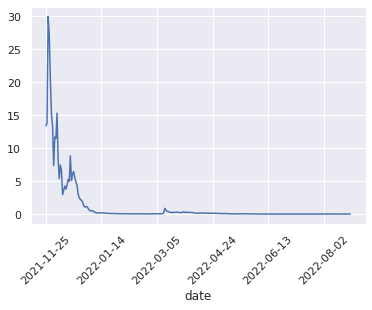

In [36]:
df.loc[(df['contractAddress'] == '0xa0c8c80ed6b7f09f885e826386440b2349f0da7e')&(df['chain'] == 'binance')].sort_values('date', ascending=True).set_index('date')['priceUSD'].plot(rot=45)